# Enclosed tessellation

Enclosed tessellation is an enhanced [morphological tessellation](tessellation.ipynb), based on predefined enclosures and building footprints. We can see enclosed tessellation as two-step partitioning of space based on building footprints and boundaries (e.g. street network, railway). Original morphological tessellation is used under the hood to partition each enclosure.

<div class="alert alert-info">
Note
    
Enclosed tessellation has been developed as a part of [Urban Grammar AI](https://urbangrammarai.github.io) research project which is publicly available and provides an example of real-world application of the concept.
</div>

In this notebook, we will look at the concept of _enclosures_ behind enclosed tessellation, generate tessellation itself and compare it to a simpler morphological tessellation.

## Enclosures

Enclosures are areas enclosed from all sides by at least one type of a barrier. Barriers are typically roads, railways, natural features like rivers and other water bodies or a coastline. In our example, we will work with roads, and illustrate the behaviour of additional barriers using artificial data.

In [1]:
import momepy
import geopandas as gpd

In [2]:
streets = gpd.read_file(momepy.datasets.get_path('bubenec'),
                        layer='streets')

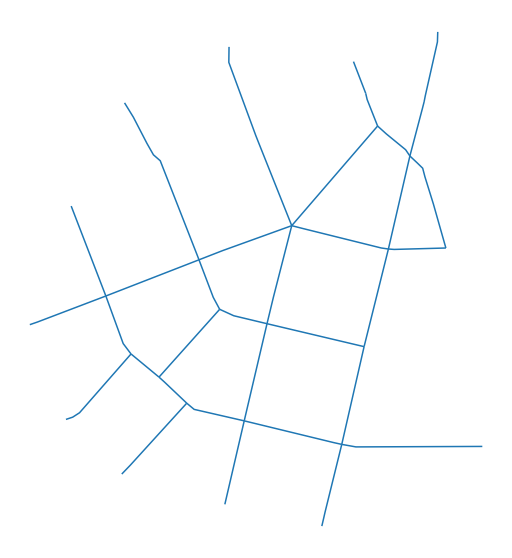

In [4]:
streets.plot(figsize=(10, 10)).set_axis_off()

It is optimal (although not necessary) to specify the external boundary of the area for which we want to generate enclosures. In this case, we use a convex hull around our street network. In the case of islands, a typical limit is a coastline, but in most of the situations, it will the boundary of the case study area.

In [5]:
convex_hull = streets.unary_union.convex_hull

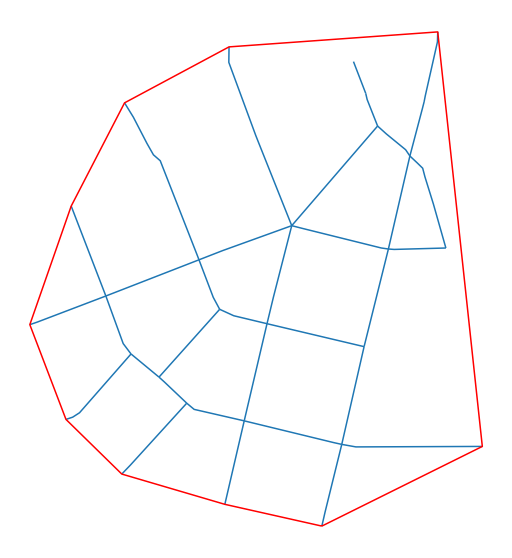

In [6]:
ax = streets.plot(figsize=(10, 10))
gpd.GeoSeries([convex_hull.boundary]).plot(ax=ax, color='r')
ax.set_axis_off()

The `momepy.enclosures` function requires `limit` as geopandas.GeoSeries or GeoDataFrame and can contain multiple objects.

Generating enclosures is then straightforward:

In [7]:
enclosures = momepy.enclosures(streets, limit=gpd.GeoSeries([convex_hull]))

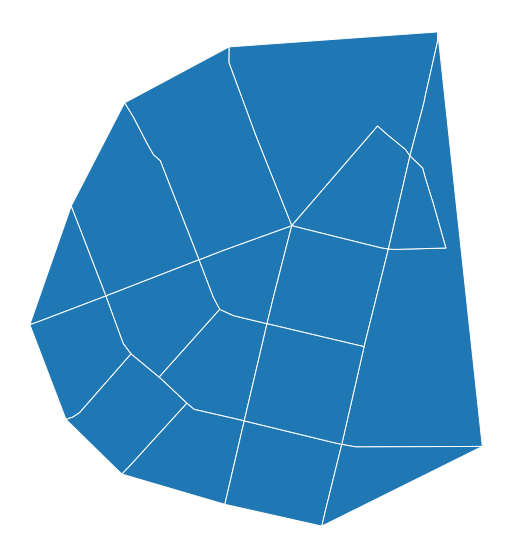

In [17]:
enclosures.plot(figsize=(10, 10), edgecolor='w').set_axis_off()

The resulting enclosures are a result of polygonization of the input. However, if there are `additional_barriers`, polygons above are further subdivided. Let's now pretend that two diagonals represent the railway as an additional barrier, and one horizontal line represents a river:

In [10]:
import numpy as np
from shapely.geometry import LineString

b = convex_hull.bounds
railway = gpd.GeoSeries(
    [LineString([(b[0], b[1]), (b[2], b[3])]), LineString([(b[0], b[3]), (b[2], b[1])])]
)
rivers = gpd.GeoSeries(
    [
        LineString([(b[0], np.mean([b[1], b[3]])), (b[2], np.mean([b[1], b[3]]))]),
        LineString([(np.mean([b[0], b[2]]), b[1]), (np.mean([b[0], b[2]]), b[3])]),
    ]
)

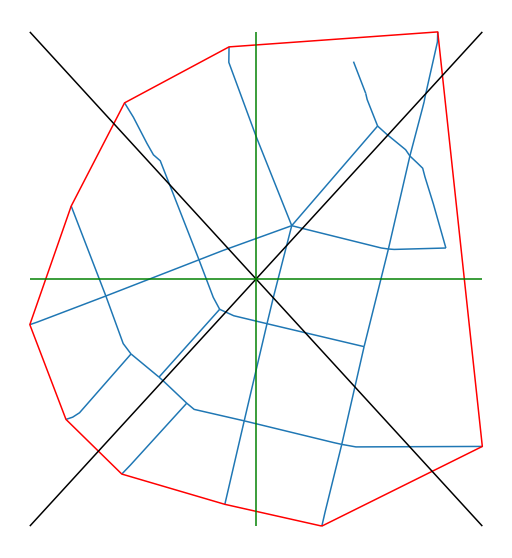

In [11]:
ax = streets.plot(figsize=(10, 10))
gpd.GeoSeries([convex_hull.boundary]).plot(ax=ax, color='r')
railway.plot(ax=ax, color='k')
rivers.plot(ax=ax, color='g')
ax.set_axis_off()

Enclosures are now defined using all the barriers.

In [12]:
enclosures_additional = momepy.enclosures(
    streets, limit=gpd.GeoSeries([convex_hull]), additional_barriers=[railway, rivers]
)

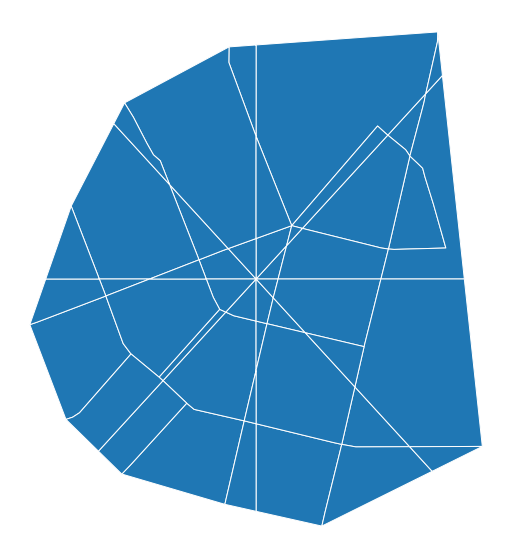

In [16]:
enclosures_additional.plot(figsize=(10, 10), edgecolor='w').set_axis_off()

## Enclosed tessellation

Having enclosures, we can now use enclosed tessellation. That, in principle, applies morphological tessellation to each enclosure using it as its limit.

For clarity, we will use the simpler enclosures we generated above.

In [19]:
buildings = gpd.read_file(momepy.datasets.get_path('bubenec'),
                          layer='buildings')

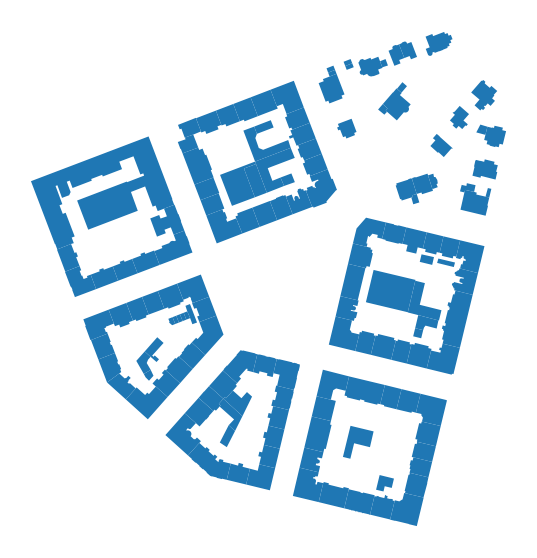

In [20]:
buildings.plot(figsize=(10, 10)).set_axis_off()

In [26]:
enclosed_tess = momepy.Tessellation(buildings, unique_id='uID', enclosures=enclosures).tessellation

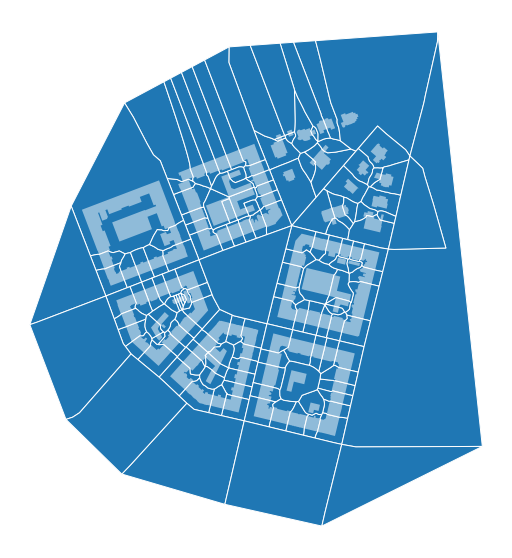

In [27]:
ax = enclosed_tess.plot(edgecolor='white', figsize=(10, 10))
buildings.plot(ax=ax, color='white', alpha=.5)
ax.set_axis_off()

### Comparison to morphological tessellation

Let's not see how enclosed tessellation differs from morphological tessellation. First, we generate morphological tessellation within the same limit.

In [28]:
morphological_tess = momepy.Tessellation(buildings, unique_id='uID', limit=convex_hull, verbose=False).tessellation

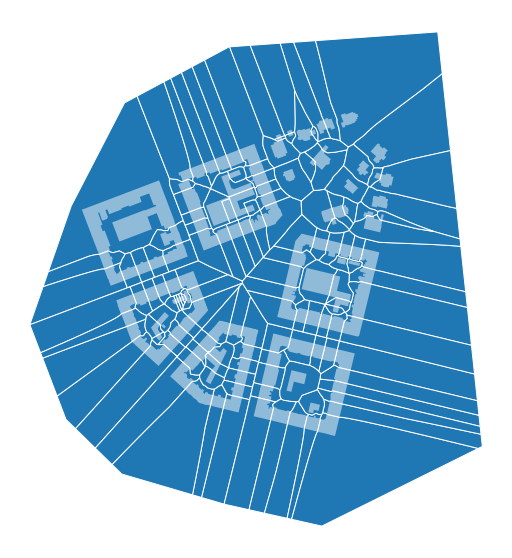

In [29]:
ax = morphological_tess.plot(edgecolor='white', figsize=(10, 10))
buildings.plot(ax=ax, color='white', alpha=.5)
ax.set_axis_off()

We can immediately see that the enclosed tessellation is tidier and resembles plots. We can overlay both for a direct comparison.

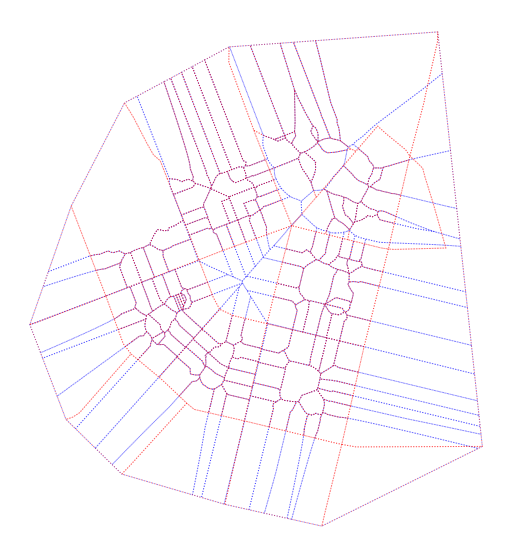

In [30]:
ax = morphological_tess.plot(edgecolor='blue', facecolor='none', linestyle='dotted', alpha=.5, figsize=(10, 10))
enclosed_tess.plot(ax=ax, edgecolor='red', facecolor='none', linestyle='dotted', alpha=.5)
ax.set_axis_off()

From this figure, we can see that a large portion of geometry overlaps, but there are apparent differences when it comes to open spaces.

## Performance

Enclosed tessellation usually is much faster and less demanding algorithm than morphological tessellation. Furthermore, it is by default parallelised using `dask`. If you do not have `dask` installed in your environment or do not want to use it, you can set `use_dask=False` to make a simple loop instead.

In [32]:
enclosed_tess = momepy.Tessellation(buildings, unique_id='uID', enclosures=enclosures, use_dask=False)

## Enclosed tessellation based on OpenStretMap

To illustrate a more real-life example, let's try to generate tessellation based on a small town retrieved from OSM. We will use `osmnx` package to get the data.

In [33]:
import osmnx as ox

gdf = ox.geometries.geometries_from_place('Kahla, Germany', tags={'building':True})
gdf_projected = ox.projection.project_gdf(gdf)
buildings = momepy.preprocess(gdf_projected, size=30,
                              compactness=0.2, islands=True, verbose=False)

streets_graph = ox.graph_from_place('Kahla, Germany', network_type='drive')
streets_graph = ox.projection.project_graph(streets_graph)
streets = ox.graph_to_gdfs(streets_graph, nodes=False, edges=True,
                           node_geometry=False, fill_edge_geometry=True)

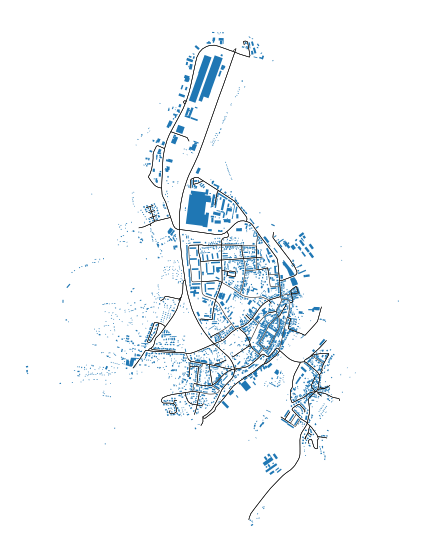

In [34]:
ax = buildings.plot(figsize=(10, 10))
streets.plot(ax=ax, color='k', linewidth=.5)
ax.set_axis_off()

### Enclosures

We will generate enclosures based on the street network and limit of using the buffer method.

In [35]:
limit = momepy.buffered_limit(buildings)
enclosures = momepy.enclosures(streets, limit=gpd.GeoSeries([limit]))

`Tessellation` requires `unique_id` to match resulting cells to original buildings. We will generate a unique ID using `momepy.unique_id`.

In [36]:
buildings['uID'] = momepy.unique_id(buildings)

At this moment, we have everything we need to generate enclosed tessellation.

### Enclosed tessellation

In [37]:
enclosed_tess = momepy.Tessellation(buildings, unique_id='uID', enclosures=enclosures).tessellation

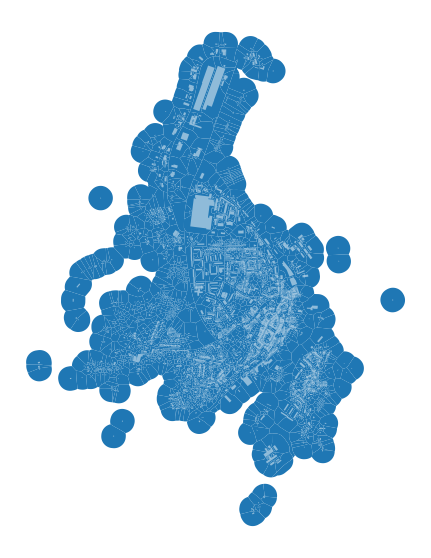

In [38]:
ax = enclosed_tess.plot(figsize=(10, 10))
buildings.plot(ax=ax, color='white', alpha=.5)
ax.set_axis_off()

Zooming closer:

(5631000.0, 5632000.0)

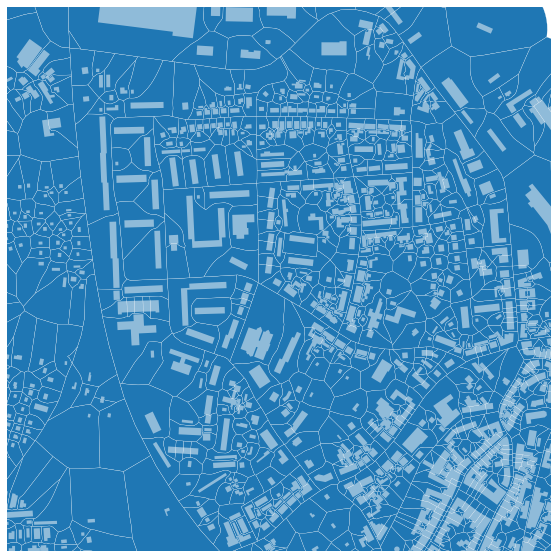

In [39]:
ax = enclosed_tess.plot(edgecolor='white', linewidth=0.2, figsize=(10, 10))
buildings.plot(ax=ax, color='white', alpha=.5)
ax.set_axis_off()
ax.set_xlim(681500, 682500)
ax.set_ylim(5631000, 5632000)

### Performance comparison

Let's time parallel enclosed tessellation, loop-based option and morphological tessellation. The notebook is run using a 4-core processor in a high-end laptop.

In [40]:
point = (40.731603, -73.977857)
dist = 1000
gdf = ox.geometries.geometries_from_point(point, dist=dist-100, tags={'building':True})
buildings = ox.projection.project_gdf(gdf)
buildings = buildings[buildings.geom_type.isin(['Polygon', 'MultiPolygon'])]
buildings['height'] = buildings['height'].fillna(0).astype(float)
buildings = buildings.explode()
buildings.reset_index(inplace=True, drop=True)

In [41]:
streets_graph = ox.graph_from_point(point, dist, network_type='drive')
streets_graph = ox.projection.project_graph(streets_graph)
edges = ox.graph_to_gdfs(streets_graph, nodes=False, edges=True,
                                   node_geometry=False, fill_edge_geometry=True)

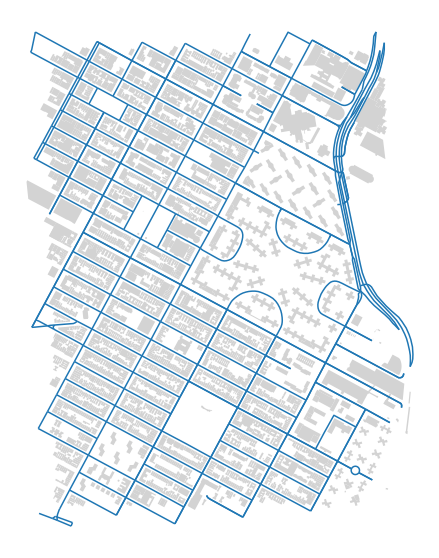

In [42]:
ax = buildings.plot(color='lightgrey', figsize=(10, 10))
edges.plot(ax=ax)
ax.set_axis_off()

In [43]:
limit = gpd.GeoSeries([buildings.unary_union.convex_hull])
enclosures = momepy.enclosures(edges, limit=limit)

In [44]:
buildings['uID'] = momepy.unique_id(buildings)

In [47]:
from time import time

times = {}

s = time()
%time parallel = momepy.Tessellation(buildings, unique_id='uID', enclosures=enclosures)
times['parallel'] = time() - s

s = time()
%time loop = momepy.Tessellation(buildings, unique_id='uID', enclosures=enclosures, use_dask=False)
times['loop'] = time() - s

s = time()
%time morphological = momepy.Tessellation(buildings, unique_id='uID', limit=limit, verbose=False)
times['morphological'] = time() - s

CPU times: user 1min 37s, sys: 4.22 s, total: 1min 41s
Wall time: 27.8 s
CPU times: user 1min 13s, sys: 654 ms, total: 1min 14s
Wall time: 1min 15s
CPU times: user 1min 9s, sys: 787 ms, total: 1min 9s
Wall time: 1min 10s


/Users/martin/Git/momepy/momepy/elements.py:365: UserWarning: Tessellation contains MultiPolygon elements. Initial objects should be edited. unique_id of affected elements: [108, 217, 630, 1623, 2432, 2435, 2520, 2523, 2608, 2615, 2619]
  "unique_id of affected elements: {}".format(list(self.multipolygons))


<AxesSubplot:>

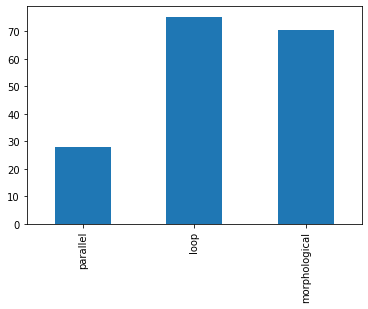

In [48]:
import pandas as pd

pd.Series(times).plot(kind='bar')

We can see about 2.5x speedup if we use the parallelised option on this particular machine. You can then scale the computation to larger machines or clusters.